In [ ]:
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


In [ ]:
!python -m pip install geopandas==0.13.0 &> /dev/null
!python -m pip install wget==3.2 &> /dev/null
!python -m pip install rioxarray==0.14.1 &> /dev/null

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import wget
import json
import zipfile
import rioxarray as rxr
import shutil
import matplotlib.pyplot as plt

In [ ]:
def min_max_elev(reclassify_dir):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1) Determine minimum and maximum elevation')
  print('-----------------------------------------------------------------------------------------------')
  if not os.path.exists(reclassify_dir):
    os.makedirs(reclassify_dir)

  # download package
  reclassify_url = 'https://github.com/chiatt/gdal_reclassify/archive/refs/heads/master.zip'
  wget.download(reclassify_url, out=reclassify_dir)

  # unzip
  extension = ".zip"
  os.chdir(reclassify_dir) # change directory from working dir to dir with files

  for item in os.listdir(reclassify_dir): # loop through items in dir
      if item.endswith(extension): # check for ".zip" extension
          file_name = os.path.abspath(item) # get full path of files
          zip_ref = zipfile.ZipFile(file_name) # create zipfile object
          zip_ref.extractall(reclassify_dir) # extract file to dir
          zip_ref.close() # close file
          os.remove(file_name) # delete zipped file

  # find name of dem
  dem_path = os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data','DEM')
  for dem_file in os.listdir(os.path.join(dem_path)):
      if dem_file.endswith(".tif"):
        dem_file_name = dem_file

  # open DEM layer
  src = rxr.open_rasterio(os.path.join(dem_path,dem_file_name), masked=True).squeeze()

  # determine minimum elevation of DEM layer
  dem_min = int(src.min())
  print('\nMinimum Elevation: ', dem_min)

  # determine maximum elevation of DEM layer
  dem_max = int(src.max())
  print('Maximum Elevation: ', dem_max)
  return(dem_max)

In [ ]:
def reclassify_dem(increment_val, min_elev, dem_max, reclassify_dir):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(2) Reclassify DEM')
  print('-----------------------------------------------------------------------------------------------')
  min_val = min_elev
  # define elevation bands
  inc_lst = ['<=0', f'<{min_elev}']

  while min_elev < (dem_max-increment_val):
      min_elev = min_elev + increment_val
      inc_lst.append(f'<{min_elev}')
  band_range = ','.join(str(x) for x in inc_lst)
  print('Elevation Band Increments: ',band_range)

  id_vals = list(range(len(inc_lst)))
  band_id = ','.join(str(i) for i in id_vals)
  print('Number of Elevation Bands: ', band_id)
  print('\n')

  # define pathways for gdal commands
  # path to gdal_reclassify.py script
  gdal_reclassify = os.path.join(reclassify_dir, 'gdal_reclassify-master', 'gdal_reclassify.py')

  # path to reclassified output raster
  elev_band_rast_path = os.path.join(reclassify_dir,'elev_bands_rast.tif')

  # path to output shapefile
  elev_band_shp_path = os.path.join(reclassify_dir,'elev_bands.shp')

  # find name of dem
  dem_path = os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data','DEM')
  for dem_file in os.listdir(os.path.join(dem_path)):
      if dem_file.endswith(".tif"):
        dem_file_name = dem_file
  dem_path_full = os.path.join(dem_path, dem_file_name)

  # write bash command to reclassify
  with open(os.path.join(variable['temporary_dir'],'reclass.sh'), 'w') as f1:
    print(f'python "{gdal_reclassify}" "{dem_path_full}" "{elev_band_rast_path}" -c "{band_range}" -r "{band_id}" -d 0 -n true -p "COMPRESS=LZW"', file=f1)

  reclass_sh_file = os.path.join(variable['temporary_dir'],'reclass.sh')
  !bash {reclass_sh_file}

  # write bash command to convert raster to shapefile
  with open(os.path.join(variable['temporary_dir'],'polygonize.sh'), 'w') as f2:
    print(f'gdal_polygonize.py "{elev_band_rast_path}" "{elev_band_shp_path}" -b 1 -f "ESRI Shapefile"', file=f2)

  poly_sh_file = os.path.join(variable['temporary_dir'],'polygonize.sh')
  !bash {poly_sh_file}

In [ ]:
def visualize_elev_bands(increment_val, min_val):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(3) Visualize and save elevation bands')
  print('-----------------------------------------------------------------------------------------------')
  # load polygon shapefile
  elev_band_shp_path = os.path.join(variable['temporary_dir'], 'elev_band','elev_bands.shp')
  elev_band_shp = gpd.read_file(elev_band_shp_path)

  # aggregate elevation bands based on ID values
  elev_band_dissolve = elev_band_shp.dissolve(by='DN')
  elev_band_dissolve.to_file(os.path.join(reclassify_dir,'elev_bands_dissolved.shp'))

  # additional columns are added, such as O_ID_1, ContourMin,and ContourMax to assist with compatibility later on in the Workflow
  # create list of the minimum contour values
  inc_min = [min_val]

  while min_val < (dem_max-increment_val):
    min_val = min_val + increment_val
    inc_min.append(min_val)
    inc_min_lst = inc_min[:-1]
  print('\nMinimum Contour Lines: ', inc_min_lst)

  # create list of the maximum contour values
  max_inc = [max_val+increment_val for max_val in inc_min_lst]
  print('Maximum Contour Lines: ', max_inc)

  # format shapefile with contour values
  elev_band_final = gpd.read_file(os.path.join(reclassify_dir,'elev_bands_dissolved.shp'))
  elev_band_final["O_ID_1"]= list(range(1, (len(elev_band_final["DN"])+1))) # define new ID column
  elev_band_final["ContourMin"]=inc_min_lst # assign minmum contour values
  elev_band_final["ContourMax"]=[max_val+increment_val for max_val in inc_min_lst] # create list of the maximum contour values
  del(elev_band_final["DN"]) # remove old ID column

  # check out table
  display(elev_band_final)

  # visualize elevation bands
  f, ax = plt.subplots(figsize=(9,10))
  elev_band_shp.plot(column='DN',categorical=False,legend=True ,ax=ax)
  ax.set(title="Elevation Bands")
  ax.set_axis_off()
  plt.show()

  # save final elevation band shapefile to drive
  elev_band_output_dir = os.path.join(variable['main_dir'], 'workflow_outputs', '1_HRU_data','Elevation_Bands')
  if not os.path.exists(elev_band_output_dir):
    os.makedirs(elev_band_output_dir)
  elev_band_final.to_file(os.path.join(elev_band_output_dir,'studyArea_elev_band.shp'))

  shutil.rmtree(os.path.join(variable['temporary_dir']))
  print('\n-----------------------------------------------------------------------------------------------')
  print('(4) Elevation Bands Complete!')
  print('-----------------------------------------------------------------------------------------------')

In [ ]:
def upload_elev_bands(reclassify_dir):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1) Upload Elevation Band Shapefile')
  print('-----------------------------------------------------------------------------------------------')
  # find name of shapefile
  for shp_file in os.listdir(os.path.join(variable['main_dir'], 'shapefile')):
      if shp_file.endswith(".shp"):
        shp_file_name = shp_file

  # find name of shapefile
  for elevB_file in os.listdir(reclassify_dir):
      if elevB_file.endswith(".shp"):
        elevB_file_name = elevB_file

  print('\n-----------------------------------------------------------------------------------------------')
  print('(2) Check Projection')
  print('-----------------------------------------------------------------------------------------------')

  # load study area shapefile
  shp_extent = gpd.read_file(os.path.join(variable['main_dir'], 'shapefile', shp_file_name))
  # load elevation band shapefile
  elevB_extent = gpd.read_file(os.path.join(reclassify_dir, elevB_file_name))

  if shp_extent.crs !=  elevB_extent.crs:
    # reproject
    elevB_lyr = elevB_lyr.to_crs(shp_extent.crs)
    print('\nElevation Band layer has been reprojected to match shapefile')
  else:
    elevB_lyr = elevB_extent
    print('\nCoordinate systems match')

  print('\n-----------------------------------------------------------------------------------------------')
  print('(3) Visualize and save elevation bands')
  print('-----------------------------------------------------------------------------------------------')

  # check out table
  display(elevB_lyr)

  # visualize elevation bands
  f, ax = plt.subplots(figsize=(9,10))
  elevB_lyr.plot(categorical=False,legend=True ,ax=ax)
  ax.set(title="Elevation Bands")
  ax.set_axis_off()
  plt.show()

  # save final elevation band shapefile to drive
  elev_band_output_dir = os.path.join(variable['main_dir'], 'workflow_outputs', '1_HRU_data','Elevation_Bands')
  if not os.path.exists(elev_band_output_dir):
    os.makedirs(elev_band_output_dir)
  elevB_lyr.to_file(os.path.join(elev_band_output_dir,'studyArea_elev_band.shp'))

In [ ]:
def remove_temp_data():
  if os.path.exists(os.path.join(variable['temporary_dir'])):
    shutil.rmtree(os.path.join(variable['temporary_dir']))

In [ ]:
main_dir = '/content/google_drive/MyDrive/Developers_Magpie_Workflow'

with open(os.path.join(main_dir,"configuration_file.json"), "r") as f:
    variable = json.load(f)

drag-and-drop the elevation band shapefile into the following folder: /content/google_drive/MyDrive/Developers_Magpie_Workflow/temporary_data/elev_band
Have you uploaded the elevation band layer (yes or no): yes

-----------------------------------------------------------------------------------------------
(1) Upload Elevation Band Shapefile
-----------------------------------------------------------------------------------------------
(1a) drag-and-drop elevation band shapefile into temporary elevation band folder located within the main directory

-----------------------------------------------------------------------------------------------
(2) Check Projection
-----------------------------------------------------------------------------------------------

Coordinate systems match

-----------------------------------------------------------------------------------------------
(3) Visualize and save elevation bands
--------------------------------------------------------------------

,O_ID_1,ContourMin,ContourMax,geometry
0,1,1000,1200,"MULTIPOLYGON (((-114.30707 49.55242, -114.3070..."
1,2,1200,1400,"MULTIPOLYGON (((-114.19631 49.53221, -114.1963..."
2,3,1400,1600,"MULTIPOLYGON (((-114.60459 49.62680, -114.6045..."
3,4,1600,1800,"MULTIPOLYGON (((-114.44532 49.52332, -114.4428..."
4,5,1800,2000,"MULTIPOLYGON (((-114.55042 49.55485, -114.5512..."
5,6,2000,2200,"MULTIPOLYGON (((-114.63855 49.61548, -114.6377..."
6,7,2200,2400,"MULTIPOLYGON (((-114.65714 49.65995, -114.6579..."
7,8,2400,2600,"MULTIPOLYGON (((-114.64178 49.66399, -114.6434..."
8,9,2600,2800,"MULTIPOLYGON (((-114.66038 49.85237, -114.6619..."
9,10,2800,3000,"MULTIPOLYGON (((-114.68706 49.88794, -114.6870..."


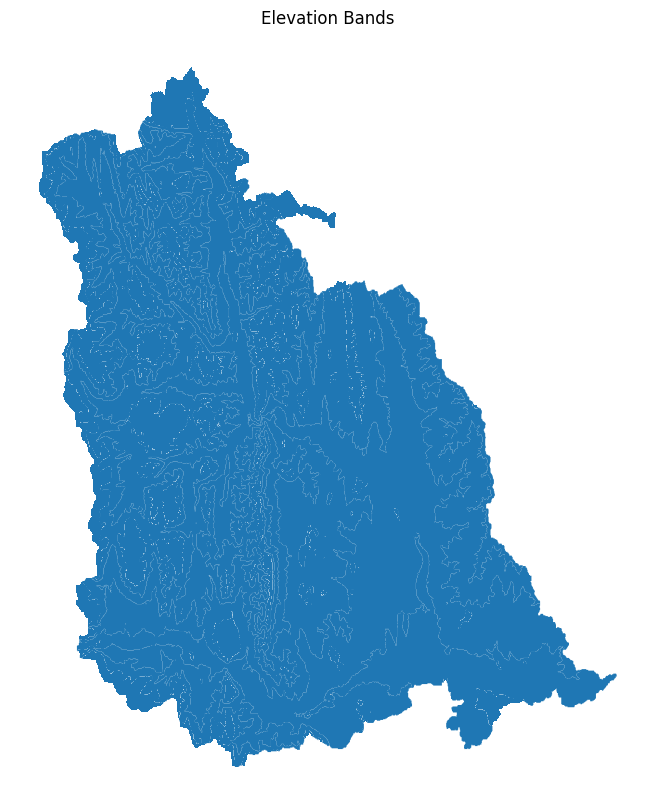

In [ ]:
# read in variable
with open(os.path.join(main_dir,"configuration_file.json"), "r") as f:
    variable = json.load(f)

if variable['generate_elev_bands'] == "yes" and variable['upload_elev_bands'] == "yes":
  print('Error: Please define whether you are using section 1c to generate the elevation band layer OR upload your own, users cannot have both set as yes')
elif variable['generate_elev_bands'] == "yes" and variable['upload_elev_bands'] == "no":
  # set directory/path
  reclassify_dir = os.path.join(variable['temporary_dir'], 'elev_band')
  if not os.path.exists(reclassify_dir):
    os.makedirs(reclassify_dir)
  # step 1
  dem_max = min_max_elev(reclassify_dir)
  # step 2
  if variable['min_elev'] == "NA":
    response_min_elev = input("Please enter the minimum elevation here: ")
    reclassify_dem(int(variable['increment_val']), int(response_min_elev), int(dem_max), reclassify_dir)
  else:
    reclassify_dem(int(variable['increment_val']), int(variable['min_elev']), int(dem_max), reclassify_dir)
  # step 3
  if variable['min_elev'] == "NA":
    visualize_elev_bands(int(variable['increment_val']),int(response_min_elev))
  else:
    visualize_elev_bands(int(variable['increment_val']),int(variable['min_elev']))
elif variable['generate_elev_bands'] == "no" and variable['upload_elev_bands'] == "yes":
  # set directory/path
  reclassify_dir = os.path.join(variable['temporary_dir'], 'elev_band')
  if not os.path.exists(reclassify_dir):
      os.makedirs(reclassify_dir)
  print(f'drag-and-drop the elevation band shapefile into the following folder: {reclassify_dir}')
  response = input("Have you uploaded the elevation band layer (yes or no): ")
  if response == "yes":
    upload_elev_bands(reclassify_dir)
    remove_temp_data()
else:
  print('( ) Elevation bands section has been skipped')